In [144]:
import os
import pandas as pd
import ast
from omegaconf import OmegaConf
import seaborn as sns

In [138]:

# set the path to the top-level directory containing the multirun folders
top_dir = 'multirun/'

# define a lambda function to convert the rewards column to a nested list of integers
rewards_converter = lambda x: [[int(val) for val in row[1:-1].split()] for row in x.split('\n') if row]

# initialize an empty list to hold the dataframes
df_list = []
df_flat = []

# traverse the directory structure and load the rewards.csv files
#for date_folder in os.listdir(top_dir):


date_folder = '2023-05-07'

date_path = os.path.join(top_dir, date_folder)
#if not os.path.isdir(date_path):
#    continue
for time_folder in os.listdir(date_path):
    time_path = os.path.join(date_path, time_folder)
    if not os.path.isdir(time_path):
        continue
    for exp_folder in os.listdir(time_path):
        exp_path = os.path.join(time_path, exp_folder)
        if not os.path.isdir(exp_path):
            continue
        reward_file = os.path.join(exp_path, 'rewards.csv')
        if not os.path.isfile(reward_file):
            continue
        # load the rewards.csv file and add additional columns
        #converters = {'rewards': lambda x: ast.literal_eval(x) if isinstance(x, str) else None}
        try:
            df = pd.read_csv(reward_file)#, converters=converters)
        except Exception as e:
            print(f"Error loading {reward_file}: {e}")
            continue
        
        rewards = [float(t.strip('[ ]')) for t in df['rewards'][0].split('\n')]
        #for i, reward in enumerate(rewards):
        #    df[f'reward_trial{i}'] = reward
        rewards = pd.DataFrame(rewards, columns=['rewards'])
        rewards.index.name = 'trial'
        #rewards = rewards.T
        
        #df.drop(columns=['rewards'], inplace=True)
        #rewards['date'] = date_folder
        #rewards['time'] = time_folder
        #rewards['experiment'] = exp_folder
        #drop these, because they come from the overrides file
        df.drop(columns=['optimizer', 'seed', 'phys_nn_config'], inplace=True)

        df = rewards
        #read overrides and add as columns
        override_file = os.path.join(exp_path, '.hydra/overrides.yaml')
        if not os.path.isfile(reward_file):
            continue

        overrides = OmegaConf.load(override_file)                
        overrides_list = OmegaConf.to_container(overrides, resolve=True)
        config_dict = {}
        for item in overrides_list:
            key, value = item.split("=")
            config_dict[key.strip()] = value.strip()

        overrides_df = pd.DataFrame.from_dict(config_dict, orient='index').T
        overrides_df.rename(columns={'optimizer.population_size': 'population_size', 
                     'optimizer.num_iterations': 'num_iterations',
                     'agent.planning_horizon': 'planning_horizon',
                   }, inplace=True)
        
        df= pd.concat([overrides_df, df], axis=1)
        df = df.fillna(method = 'ffill')
        df['trial'] = df.index
        #df.reset_index(drop=True, inplace=True)
        df_flat.append(df)
        
        df = df.set_index(list(overrides_df.columns) + ['trial'])
        df_list.append(df)

# concatenate the dataframes into one
result_m = pd.concat(df_list)
result_s = pd.concat(df_flat, ignore_index=True)


In [141]:
for param in overrides_df.columns:
    print('{}: {}'.format(param, result_s[param].unique()))

optimizer: ['CEM']
num_iterations: ['5' '10']
population_size: ['100' '500' '50']
planning_horizon: ['25' '15' '50']
seed: ['3']
phys_nn_config: ['0' '2' '1' '3']
physics_model: ['cartpole' 'sindy']


In [154]:
result_s

,optimizer,num_iterations,population_size,planning_horizon,seed,phys_nn_config,physics_model,rewards,trial
0,CEM,5,100,25,3,0,cartpole,0.0,0
1,CEM,5,100,25,3,0,cartpole,200.0,1
2,CEM,5,100,25,3,0,cartpole,200.0,2
3,CEM,5,100,25,3,0,cartpole,200.0,3
4,CEM,5,100,25,3,0,cartpole,200.0,4
...,...,...,...,...,...,...,...,...,...
1247,CEM,5,50,15,3,0,cartpole,200.0,6
1248,CEM,5,50,15,3,0,cartpole,200.0,7
1249,CEM,5,50,15,3,0,cartpole,200.0,8
1250,CEM,5,50,15,3,0,cartpole,200.0,9


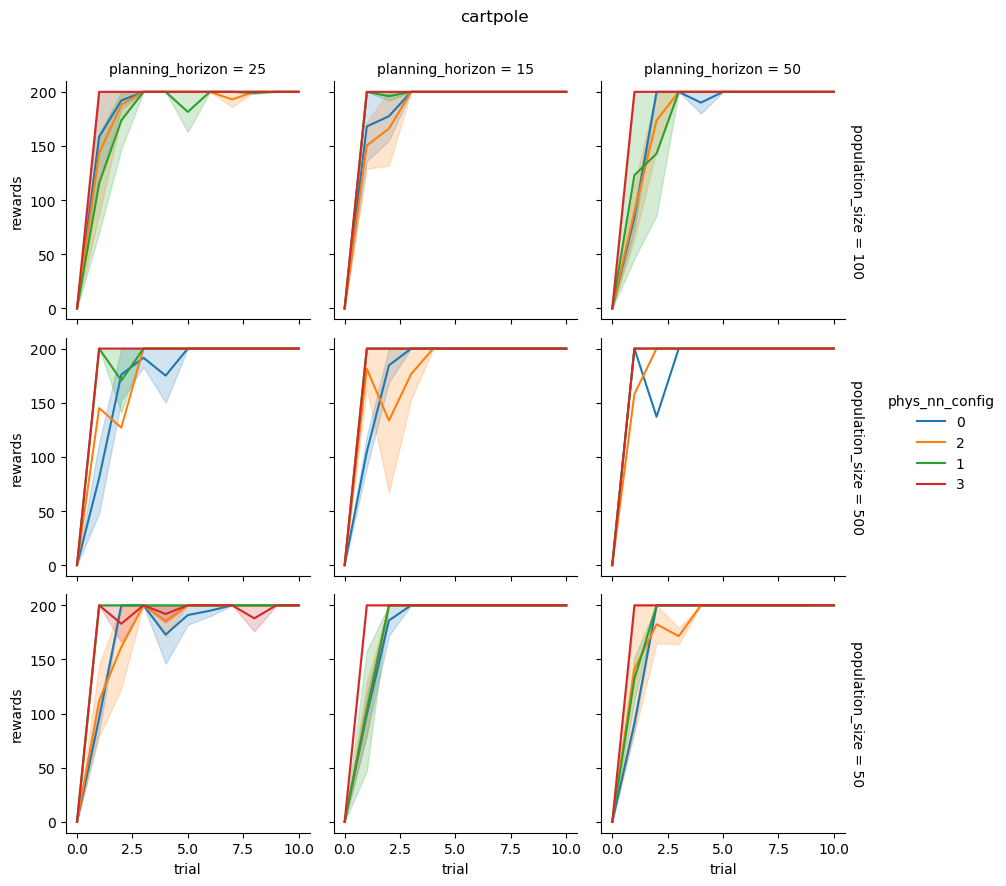

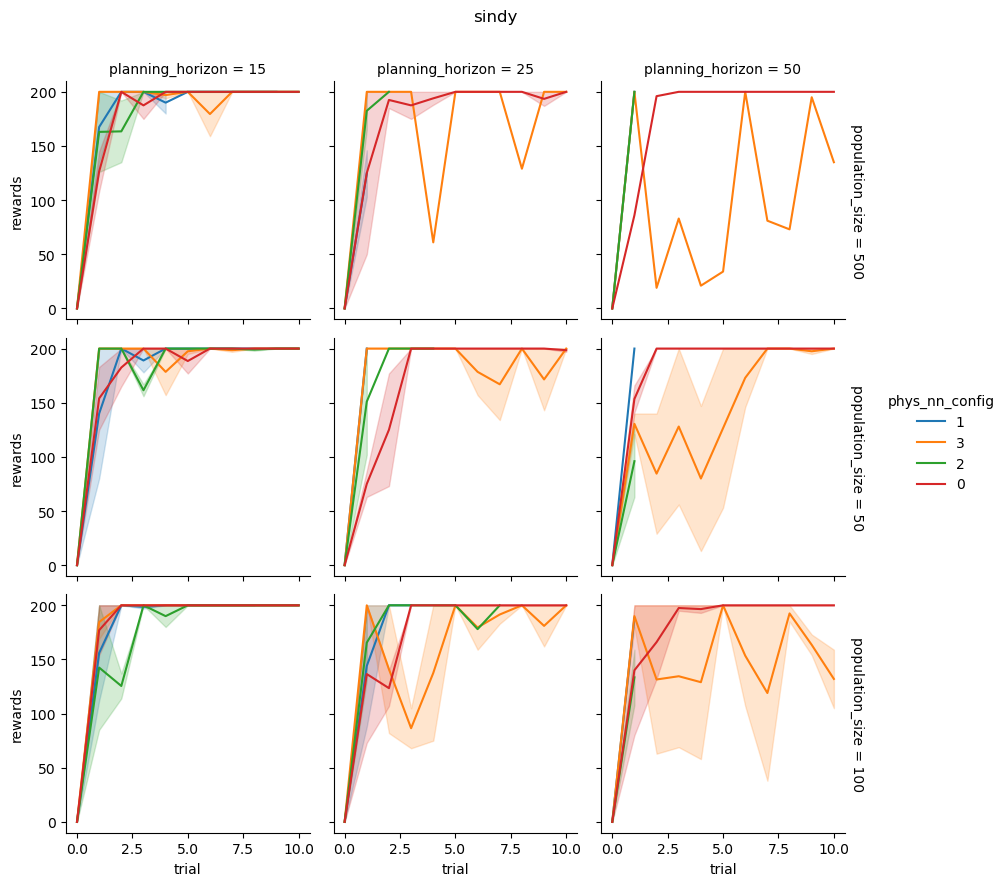

In [162]:


for model in result_s['physics_model'].unique():
    g = sns.FacetGrid(result_s[result_s['physics_model'] == model], row="population_size", col="planning_horizon",
                    hue = 'phys_nn_config', 
                    margin_titles=True)

    g.map(sns.lineplot, "trial", "rewards", )
    g.add_legend()
    # add title
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(model)



In [156]:
g = sns.FacetGrid(
    data=result_m, 
    x='trial',
    y='rewards',
    col='optimizer', #'num_iterations', 'population_size', 'planning_horizon'],
    row='phys_nn_config',
    hue='physics_model',
    kind='line',
    marker='o',
    legend='full'
)

# Set the plot title
g.fig.suptitle('Rewards vs. Number of Trials')

# Adjust the layout of subplots
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

TypeError: __init__() got an unexpected keyword argument 'x'

In [123]:
pd.concat(result_df)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [48]:
melted_df = pd.melt(result_df,
                    id_vars=['optimizer', 'optimizer.num_iterations', 'optimizer.population_size',
                             'agent.planning_horizon', 'seed', 'phys_nn_config', 'physics_model',
                             'date', 'time', 'experiment'],
                    value_vars=['reward_trial1', 'reward_trial2', 'reward_trial3', 'reward_trial4',
                                'reward_trial5', 'reward_trial6', 'reward_trial7', 'reward_trial8',
                                'reward_trial9', 'reward_trial10'],
                    var_name='trial',
                    value_name='reward')
melted_df

,optimizer,optimizer.num_iterations,optimizer.population_size,agent.planning_horizon,seed,phys_nn_config,physics_model,date,time,experiment,trial,reward
0,CEM,5,100,25,3,0,cartpole,2023-05-07,16-28-04,33,reward_trial1,200.0
1,CEM,5,100,15,3,0,cartpole,2023-05-07,16-28-04,25,reward_trial1,200.0
2,CEM,5,500,15,3,2,cartpole,2023-05-07,16-28-04,53,reward_trial1,163.0
3,CEM,10,100,15,3,0,cartpole,2023-05-07,16-28-04,97,reward_trial1,136.0
4,CEM,10,500,25,3,1,cartpole,2023-05-07,16-28-04,131,reward_trial1,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1325,CEM,5,50,50,3,3,sindy,2023-05-07,16-28-04,22,reward_trial10,200.0
1326,CEM,10,500,15,3,2,cartpole,2023-05-07,16-28-04,125,reward_trial10,200.0
1327,CEM,10,500,15,3,3,sindy,2023-05-07,16-28-04,126,reward_trial10,200.0
1328,CEM,5,50,50,3,0,sindy,2023-05-07,16-28-04,16,reward_trial10,200.0


In [30]:
pd.concat(df_list,axis = 0, ignore_index=True)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
#alans batch:

result_df = result_df[result_df['date'] == '2023-05-07' ]
df_filtered = result_df
df_filtered

,optimizer,seed,phys_nn_config,reward_trial0,reward_trial1,reward_trial2,reward_trial3,reward_trial4,reward_trial5,reward_trial6,reward_trial7,reward_trial8,reward_trial9,reward_trial10,date,time,experiment
50,CEM,3,0,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,33
51,CEM,3,0,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,25
52,CEM,3,2,0.0,163.0,67.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,53
53,CEM,3,0,0.0,136.0,155.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,97
54,CEM,3,1,0.0,200.0,141.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,CEM,3,3,0.0,121.0,140.0,200.0,147.0,200.0,200.0,200.0,200.0,195.0,200.0,2023-05-07,16-28-04,22
179,CEM,3,2,0.0,200.0,200.0,153.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,125
180,CEM,3,3,0.0,200.0,200.0,200.0,194.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,126
181,CEM,3,0,0.0,141.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-07,16-28-04,16


In [ ]:
result_df = result_df[result_df['date'] == '2023-05-04' ]
result_df['time'] = pd.to_datetime(result_df['time'], format='%H-%M-%S')
df_filtered = result_df[result_df['time'] > pd.to_datetime('12:00:00', format='%H:%M:%S')]


#select columns with time after 12:00
#result_df = result_df[result_df['time'] > '12:00:00' ]
result_df


,optimizer,seed,phys_nn_config,reward_trial0,reward_trial1,reward_trial2,reward_trial3,reward_trial4,reward_trial5,reward_trial6,reward_trial7,reward_trial8,reward_trial9,reward_trial10,date,time,experiment
0,CEM,1,0,0.0,98.0,152.0,164.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 04:46:01,0
1,CEM,1,0,0.0,79.0,200.0,183.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 04:46:01,1
2,ICEM,1,1,0.0,55.0,200.0,200.0,160.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,3
3,ICEM,1,0,0.0,55.0,166.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,0
4,ICEM,1,2,0.0,185.0,136.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,5
5,ICEM,1,2,0.0,109.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,4
6,ICEM,1,1,0.0,189.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,2
7,ICEM,1,3,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,7
8,ICEM,1,3,0.0,200.0,200.0,200.0,147.0,104.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,6
9,ICEM,1,0,0.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,2023-05-04,1900-01-01 12:06:58,1
